In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.linear_model import LinearRegression
from geopy import distance,Nominatim

In [33]:
def date_parser(date):
    formato = "%d-%m-%Y/%H:%M"
    return pd.to_datetime(date, format=formato)

df = pd.read_csv('tabelaTotal.csv',parse_dates=['dataTimeUpload'],index_col=['dataTimeUpload'],date_parser=date_parser)

In [34]:
df['nome'] = df['nome'].apply(lambda x: 1 if isinstance(x,str) else 0)
df = pd.concat([df,pd.get_dummies(df['sexo'])],axis=1).drop('sexo',axis=1)
df = pd.concat([df,pd.get_dummies(df['idUsuario'])],axis=1).drop('idUsuario',axis=1)

In [35]:
df['distancia'] = df['distancia'].apply(lambda x:'Belém' if x == 'Belem' else x)
df['distancia'] = df['distancia'].apply(lambda x:'Maranhão' if x == 'maranhao' else x)

In [36]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="myGeocoder")

coords = (geolocator.geocode('R. da Basílica - Nazaré, Belém - PA').latitude, geolocator.geocode('R. da Basílica - Nazaré, Belém - PA').longitude)

In [37]:
df['Coordenadas_CasaPlacido'] = df['atendimento'].apply(lambda x: coords)

In [38]:
df['distancia']

dataTimeUpload
2023-10-05 15:10:00     Santa Isabel do Pará
2023-10-05 15:10:00      São Miguel do Guamá
2023-10-05 15:10:00                Castanhal
2023-10-05 15:10:00                Castanhal
2023-10-05 15:10:00                    Belém
                               ...          
2023-10-09 21:03:00               Ananindeua
2023-10-09 21:03:00                     Moju
2023-10-09 21:03:00               Ananindeua
2023-10-09 21:03:00    Santa Bárbara do Pará
2023-10-09 21:03:00     Santa Isabel do Pará
Name: distancia, Length: 1538, dtype: object

In [39]:
def retornar_lat_long(x):
    try:
        location = geolocator.geocode(x)
        return (location.latitude,location.longitude)
    except error as err:
        print(err)

array_temporario = df['distancia'].drop_duplicates().apply(retornar_lat_long)
df['cidades'] = df['distancia'].copy()
for index in range(len(array_temporario)):
    df['distancia'] = df['distancia'].apply(lambda x: array_temporario[index] if x == df['distancia'].drop_duplicates()[index] else x)

In [40]:
df['distancia'] = df['distancia'].apply(lambda x: (distance.distance(df['Coordenadas_CasaPlacido'][0], x).km))

In [41]:
df

,id,nomeUsuario,nome,idade,atendimento,distancia,Feminino,Masculino,Outros,Brenda Lima@gmail.com,...,moreiraleonardo0707@gmail.com,ph.leao16@gmail.com,registroquestionavel@gmail.com,rellanmonteiro30@gmail.com,thalisonlob5@gmail.com,thiagoferreiratome@gmail.com,vitorgames11br@gmail.com,wallaceney.2005@gmail.com,Coordenadas_CasaPlacido,cidades
dataTimeUpload,,,,,,,,,,,,,,,,,,,,,
2023-10-05 15:10:00,555,Iagozozo@outlook.com,1,40,Casa de placido,39.625189,1,0,0,0,...,0,0,0,0,0,0,0,0,"(-1.452268, -48.4813879)",Santa Isabel do Pará
2023-10-05 15:10:00,556,Iagozozo@outlook.com,1,63,Casa de placido,113.286507,1,0,0,0,...,0,0,0,0,0,0,0,0,"(-1.452268, -48.4813879)",São Miguel do Guamá
2023-10-05 15:10:00,557,Iagozozo@outlook.com,1,32,Casa de placido,64.663263,0,1,0,0,...,0,0,0,0,0,0,0,0,"(-1.452268, -48.4813879)",Castanhal
2023-10-05 15:10:00,558,Iagozozo@outlook.com,1,14,Casa de placido,64.663263,0,1,0,0,...,0,0,0,0,0,0,0,0,"(-1.452268, -48.4813879)",Castanhal
2023-10-05 15:10:00,559,Iagozozo@outlook.com,1,49,Casa de placido,1.474705,0,1,0,0,...,0,0,0,0,0,0,0,0,"(-1.452268, -48.4813879)",Belém
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-09 21:03:00,10768,igorcosta32536@gmail.com,1,17,Casa de placido,12.391583,1,0,0,0,...,0,0,0,0,0,0,0,0,"(-1.452268, -48.4813879)",Ananindeua
2023-10-09 21:03:00,10769,igorcosta32536@gmail.com,1,19,Casa de placido,57.882144,1,0,0,0,...,0,0,0,0,0,0,0,0,"(-1.452268, -48.4813879)",Moju
2023-10-09 21:03:00,10770,igorcosta32536@gmail.com,1,49,Casa de placido,12.391583,1,0,0,0,...,0,0,0,0,0,0,0,0,"(-1.452268, -48.4813879)",Ananindeua


In [42]:
df_temp = df.resample('d').sum()

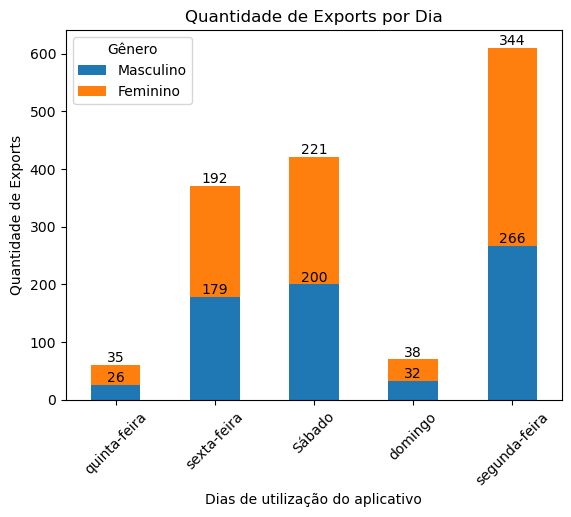

In [43]:
import locale
import matplotlib.pyplot as plt
import pandas as pd

# Configurar o idioma para Português
locale.setlocale(locale.LC_TIME, 'pt_BR.UTF-8')

df_temp['dia_da_semana'] = df_temp.index.strftime('%A')
df_temp['dia_da_semana'] = df_temp['dia_da_semana'].apply(lambda x: 'Sábado' if x == 'sÃ¡bado' else x)

# Seus dados
data = {
    'Total': df_temp['nome'],
    'Masculino': df_temp['Masculino'],
    'Feminino': df_temp['Feminino'],
}

df_temp2 = pd.DataFrame(data)

# Cores das barras
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Criar o gráfico de barras empilhadas
ax = df_temp2.plot(x='Total', kind='bar', stacked=True, color=colors)

# Configurações adicionais do gráfico
plt.xlabel('Dias de utilização do aplicativo')
plt.ylabel('Quantidade de Exports')
plt.title('Quantidade de Exports por Dia')

# Defina os rótulos do eixo x manualmente
plt.xticks(range(len(df_temp['dia_da_semana'])), df_temp['dia_da_semana'])

# Adicionar rótulos às barras
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # Evita rótulos em barras vazias
        ax.annotate(f'{height:.0f}', (x + width / 2, y + height), ha='center', va='bottom')

# Rotacionar os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45)


# Mostrar o gráfico
plt.legend(title='Gênero')
plt.show()

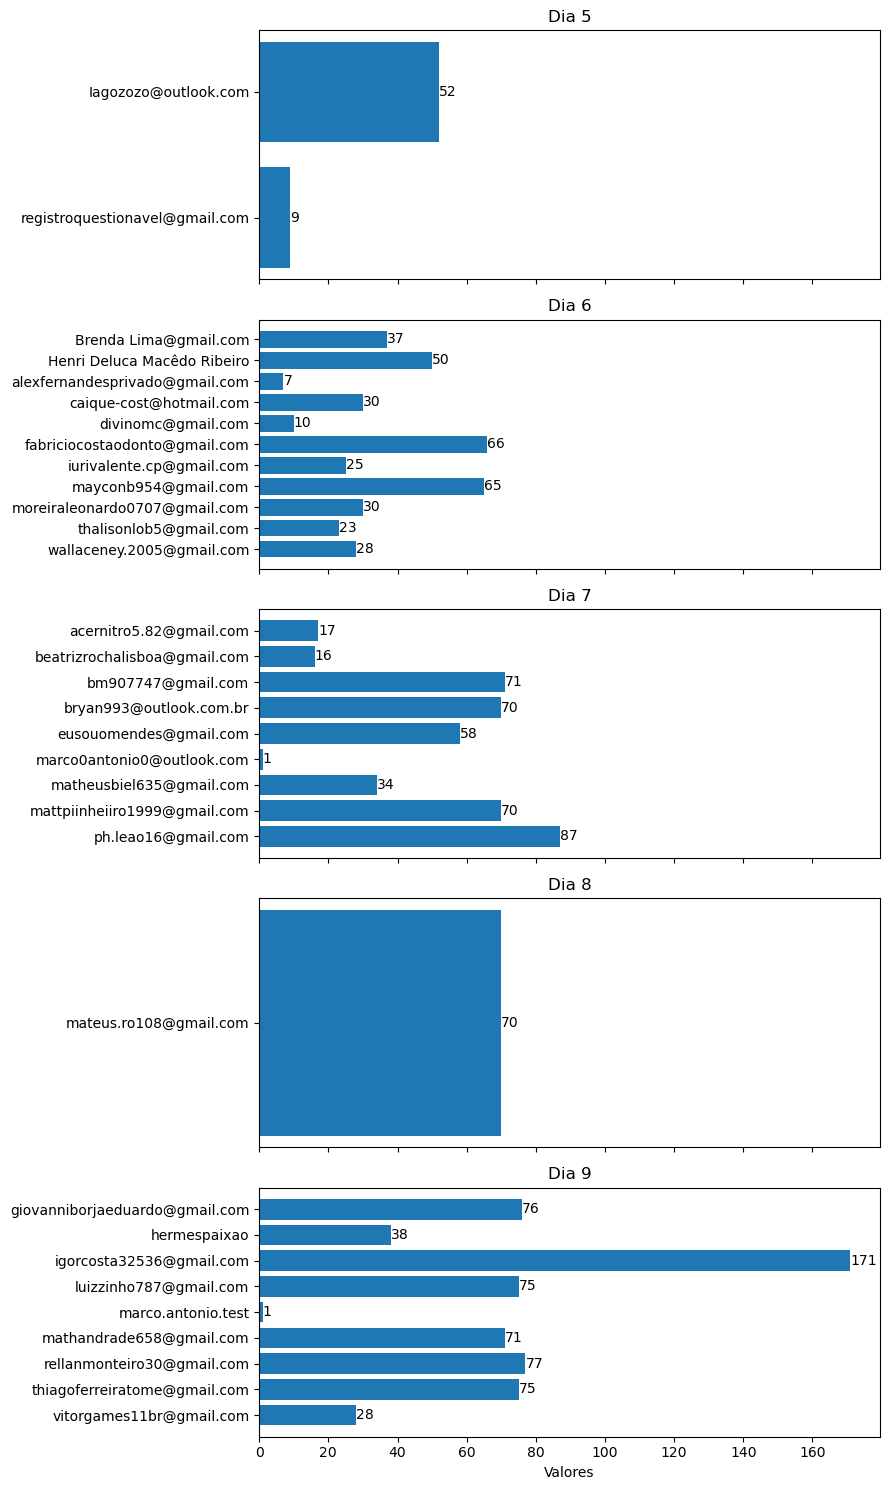

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Suponha que 'df_temp' seja o seu DataFrame
data_alvo = '2023-10-05'
coluna_alvo = 'Brenda Lima@gmail.com'

# Obtenha os dias únicos no índice
dias_unicos = df_temp.index.day.unique()

# Crie uma figura com subplots para cada dia
fig, axs = plt.subplots(len(dias_unicos), 1, figsize=(9, 3*len(dias_unicos)), sharex=True)

for i, day in enumerate(dias_unicos):
    intervalo_datas = df_temp.loc[f'2023-10-0{day}':f'2023-10-0{day}', coluna_alvo:].drop('dia_da_semana',axis=1)
    colunas_sem_zero = intervalo_datas.loc[:, ~(intervalo_datas == 0).all()]
    
    values = colunas_sem_zero.values[0]
    columns = colunas_sem_zero.columns
    
    axs[i].barh(y=columns, width=values)
    axs[i].set_title(f'Dia {day}')
    axs[i].invert_yaxis()
    
    for j, value in enumerate(values):
        axs[i].text(value, j, f'{int(value)}', va='center', fontsize=10)

plt.xlabel('Valores')
plt.tight_layout()
plt.show()


In [47]:
df.head(2)

,id,nomeUsuario,nome,idade,atendimento,distancia,Feminino,Masculino,Outros,Brenda Lima@gmail.com,...,moreiraleonardo0707@gmail.com,ph.leao16@gmail.com,registroquestionavel@gmail.com,rellanmonteiro30@gmail.com,thalisonlob5@gmail.com,thiagoferreiratome@gmail.com,vitorgames11br@gmail.com,wallaceney.2005@gmail.com,Coordenadas_CasaPlacido,cidades
dataTimeUpload,,,,,,,,,,,,,,,,,,,,,
2023-10-05 15:10:00,555,Iagozozo@outlook.com,1,"(27.0, 49.0]",Casa de placido,39.625189,1,0,0,0,...,0,0,0,0,0,0,0,0,"(-1.452268, -48.4813879)",Santa Isabel do Pará
2023-10-05 15:10:00,556,Iagozozo@outlook.com,1,"(49.0, 71.0]",Casa de placido,113.286507,1,0,0,0,...,0,0,0,0,0,0,0,0,"(-1.452268, -48.4813879)",São Miguel do Guamá


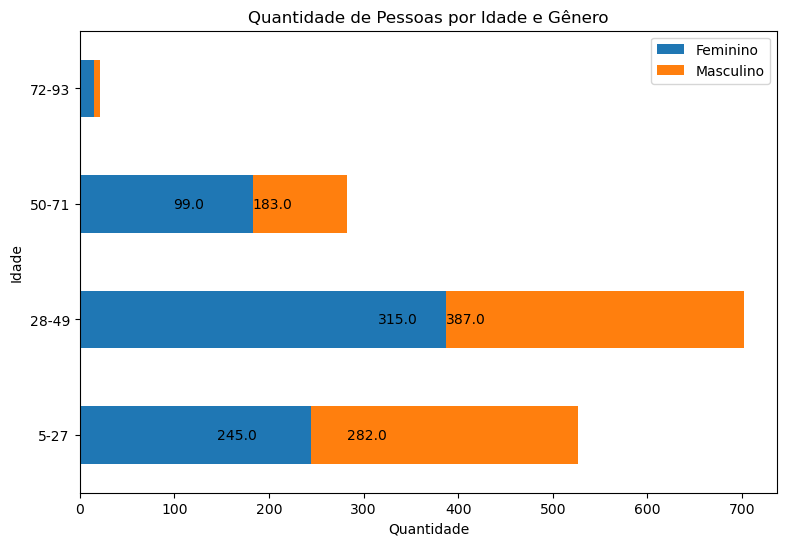

In [106]:
# Crie um gráfico de barras empilhado
ax = df[['Feminino', 'Masculino']].groupby(df['idade']).sum().plot(kind='barh', stacked=True,figsize=(9, 6))
ax.set_yticklabels(ticks)
ax.set_xlabel("Quantidade")
ax.set_ylabel("Idade")
ax.set_title("Quantidade de Pessoas por Idade e Gênero")
# Adicione os valores nas barras
for i, row in enumerate(df[['Feminino', 'Masculino']].groupby(df['idade']).sum().iterrows()):
    for j, val in enumerate(row[1]):
        if (val == 7) or (row[1][0] == 15):
            continue
        elif val != 245:
            ax.text(val, i, str(val), va='center', fontsize=10)
        else:
            ax.text(val-100, i, str(val), va='center', fontsize=10)

plt.show()

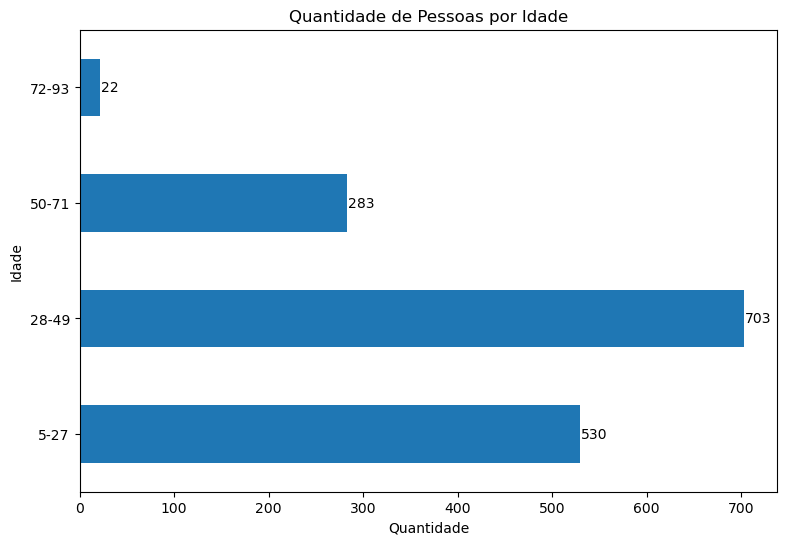

In [107]:
#df['idade'] = pd.cut(df['idade'],4)
ticks = ['5-27','28-49','50-71','72-93']

# Aumente o tamanho horizontal da figura
plt.figure(figsize=(9, 6))  # Ajuste os valores (largura, altura) conforme necessário

# Crie o gráfico de barras horizontal
ax = df['idade'].value_counts().sort_index().plot(kind='barh')
ax.set_yticklabels(ticks)
ax.set_xlabel("Quantidade")
ax.set_ylabel("Idade")
ax.set_title("Quantidade de Pessoas por Idade")

# Adicione os valores nas barras
for i, v in enumerate(df['idade'].value_counts().sort_index()):
    ax.text(v + 1, i, str(v), va='center', fontsize=10)

plt.show()